In [15]:
import os
from google.colab import drive
import tarfile

# Connect to google drive
drive.mount('/content/drive')
tar_path = '/content/drive/My Drive/CINIC-10.tar.gz'

# Extract dataset into colab from google drive
if os.path.exists(tar_path):
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path='/content/CINIC-10')
        print("Extraction successful")
else:
    print(f"File not found at {tar_path}")

!ls /content/CINIC-10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction successful
imagenet-contributors.csv  README.md  synsets-to-cifar-10-classes.txt  test  train  valid


## Load & Prep Data

- This code defines a class, CINIC10Dataset, to load and prepare the CINIC-10 dataset, which includes train, validation, and test sets.
- Initially, it calculates the dataset's mean and standard deviation for proper normalization by loading a temporary dataset and computing these values across all images. Using these calculated values, the code initializes the CINIC10Dataset class with normalization applied, creating dataloaders for training, validation, and testing, each with specified batch sizes. This setup ensures that each subset of CINIC-10 is normalized for consistent input scaling during model training and evaluation.

In [16]:
import torch, os
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CINIC10Dataset:
    def __init__(self, root, batch_size=64, transform=None):
        # Init dataset with default transformations if none provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        else:
            self.transform = transform

        self.batch_size = batch_size

        # Load datasets and apply transformations
        self.train_dataset = datasets.ImageFolder(root=os.path.join(root, 'train'), transform=self.transform)
        self.valid_dataset = datasets.ImageFolder(root=os.path.join(root, 'valid'), transform=self.transform)
        self.test_dataset = datasets.ImageFolder(root=os.path.join(root, 'test'), transform=self.transform)

        # Create dataloaders to enable batch processing
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.valid_dataloader = DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

def get_mean_and_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Sum mean and squared mean values across all batches
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    # Calculate mean and std from sums
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

dataset_path = '/content/CINIC-10'

# Load dataset without normalization to calculate mean and std
temp_transform = transforms.Compose([transforms.ToTensor()])
temp_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=2)

# Calculate mean and std for dataset
mean, std = get_mean_and_std(temp_loader)
print("Calculated Mean:", mean)
print("Calculated Std:", std)

# Init main dataset object with normalization based on calculated mean and std
cinic_dataset = CINIC10Dataset(
    root=dataset_path,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

Calculated Mean: tensor([0.4789, 0.4723, 0.4305])
Calculated Std: tensor([0.2421, 0.2383, 0.2588])


## Defining Models
### LeNet5 and ResNet9

- This code defines two convolutional neural network architectures, LeNet5 and ResNet9, both tailored for image classification tasks with 10 output classes.

  - LeNet5: This model features a classic architecture with three convolutional layers, each followed by a ReLU activation and two average pooling layers. It also includes fully connected layers at the end for classification. The design uses sequential operations where the output of one layer serves as the input for the next, and the network flattens the final convolutional layer's output before passing it to the fully connected layers.

  - ResNet9: This advanced network begins with a preparatory layer that consists of a convolution, batch normalization, and ReLU activation. It features three main blocks, each designed as a residual block that incorporates two convolutional layers with batch normalization and ReLU activations. Transitioning between blocks, the network utilizes 1x1 convolutions to adjust the number of channels, effectively allowing for dimension matching without altering spatial dimensions. To consolidate features, the network employs adaptive average pooling at the end of the last block, ensuring a fixed-size output regardless of input dimensions, which is then flattened and passed through a fully connected layer to generate class predictions.

In [17]:
from torch import nn

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.pool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResidualBlock(64, 128, stride=1, downsample=nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128)
        ))
        self.layer2 = ResidualBlock(128, 256, stride=1, downsample=nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(256)
        ))
        self.layer3 = ResidualBlock(256, 512, stride=1, downsample=nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512)
        ))

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

lenet_model = LeNet5()
print(lenet_model)

resnet_model = ResNet9()
print(resnet_model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)
ResNet9(
  (prep): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, mom

### LeNet5 with Batch Normalization
- LeNet5WithBN: This variant of LeNet5 model incorporates batch normalization after each convolutional layer.

In [18]:
class LeNet5WithBN(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5WithBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(120)
        self.pool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

LeNetWithBN_model = LeNet5WithBN()
print(LeNetWithBN_model)

LeNet5WithBN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


## Defining Training & Validation Loops
- This code defines two functions, train_model and validate_model, which handle the training and evaluation of multiple models in PyTorch.

  - train_model: This function iterates through batches in the provided dataloader to train each model using its corresponding optimizer. For each batch, it calculates the loss, performs backpropagation, and updates the model weights. It tracks the loss for each model across batches, printing the current loss every 100 batches for progress monitoring.

  - validate_model: This function evaluates each model on the validation dataset by calculating the average loss and accuracy without updating the weights (using torch.no_grad() for efficiency). The function prints each model's accuracy and average loss, storing these metrics in a dictionary for later analysis.

In [19]:
from torch.cuda.amp import autocast, GradScaler

# Init for mixed precision training
scaler = GradScaler()

def train_model(dataloader, models, loss_fn, optimizers):
    size = len(dataloader.dataset)
    # Dictionary to store loss values for each model
    model_losses = {model.__class__.__name__: [] for model in models}

    # Iterate over batches of data
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        for model, optimizer in zip(models, optimizers):
            # Reset gradients to zero
            optimizer.zero_grad()

            # Autocast to mixed precision for performance boost
            with autocast():
                pred = model(X)
                loss = loss_fn(pred, y)

            # Scale loss and perform backpropagation in mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Record loss
            model_losses[model.__class__.__name__].append(loss.item())

            # Print loss every 100 batches
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"Model {model.__class__.__name__}: Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return model_losses

def validate_model(dataloader, models, loss_fn):
    size = len(dataloader.dataset)
    # Dictionary to hold validation results
    validation_results = {}

    for model in models:
        model.eval()
        test_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Calculate average loss and accuracy
        test_loss /= len(dataloader)
        correct /= size
        validation_results[model.__class__.__name__] = (test_loss, correct)
        print(f"Model {model.__class__.__name__}: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return validation_results

<ipython-input-19-48b7e5696c6e>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Train & Visualize Results
- This code sets up and trains the three networks we defined above: LeNet5, LeNet5WithBN, and ResNet9, as well as a fourth LeNet5WithL2, which is LeNet5 with L2 regularization.

  - Initialization: The script initializes the models and moves them to a GPU if available. It also sets up optimizers for each model, where only the LeNet5WithL2's optimizer includes L2 regularization (weight decay). A cross-entropy loss function is defined to compute the loss during training and validation.

  - Training and Validation Loop: The models are trained and every 2 epochs the validation loss and accuracies are evaluated.

  - Plotting: After completing the training sessions, the script plots the training and validation loss for each model epoch-wise, alongside validation accuracy.

Model LeNet5: Accuracy: 10.0%, Avg loss: 2.304279 

Model LeNet5WithBN: Accuracy: 10.0%, Avg loss: 2.305013 

Model ResNet9: Accuracy: 10.8%, Avg loss: 2.302540 

Model LeNet5WithL2: Accuracy: 10.4%, Avg loss: 2.305739 

Epoch 1
-------------------------------
Model LeNet5: Loss: 2.308594  [    0/90000]
Model LeNet5WithBN: Loss: 2.306854  [    0/90000]


<ipython-input-19-48b7e5696c6e>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Model ResNet9: Loss: 2.298035  [    0/90000]
Model LeNet5WithL2: Loss: 2.307892  [    0/90000]
Model LeNet5: Loss: 2.292694  [ 6400/90000]
Model LeNet5WithBN: Loss: 2.256790  [ 6400/90000]
Model ResNet9: Loss: 2.249435  [ 6400/90000]
Model LeNet5WithL2: Loss: 2.241837  [ 6400/90000]
Model LeNet5: Loss: 2.095955  [12800/90000]
Model LeNet5WithBN: Loss: 1.978012  [12800/90000]
Model ResNet9: Loss: 2.111847  [12800/90000]
Model LeNet5WithL2: Loss: 2.079575  [12800/90000]
Model LeNet5: Loss: 1.939175  [19200/90000]
Model LeNet5WithBN: Loss: 1.837254  [19200/90000]
Model ResNet9: Loss: 1.982895  [19200/90000]
Model LeNet5WithL2: Loss: 1.831146  [19200/90000]
Model LeNet5: Loss: 1.970078  [25600/90000]
Model LeNet5WithBN: Loss: 1.920956  [25600/90000]
Model ResNet9: Loss: 2.182861  [25600/90000]
Model LeNet5WithL2: Loss: 1.878979  [25600/90000]
Model LeNet5: Loss: 2.143875  [32000/90000]
Model LeNet5WithBN: Loss: 1.940666  [32000/90000]
Model ResNet9: Loss: 2.057335  [32000/90000]
Model LeNe

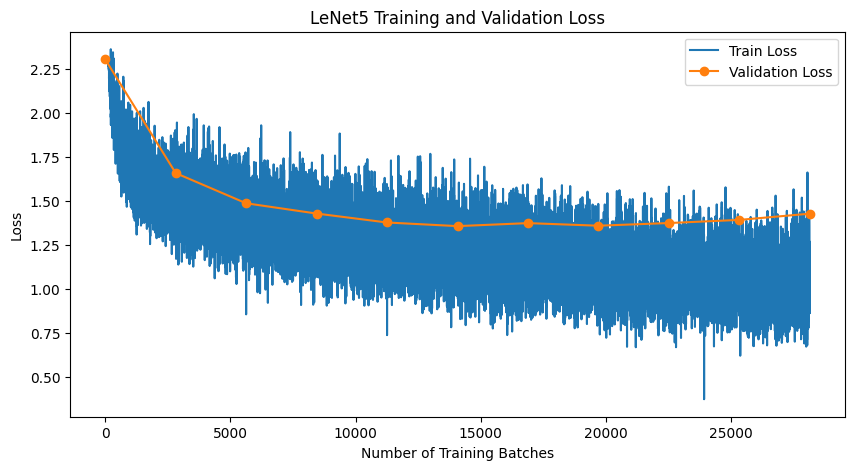

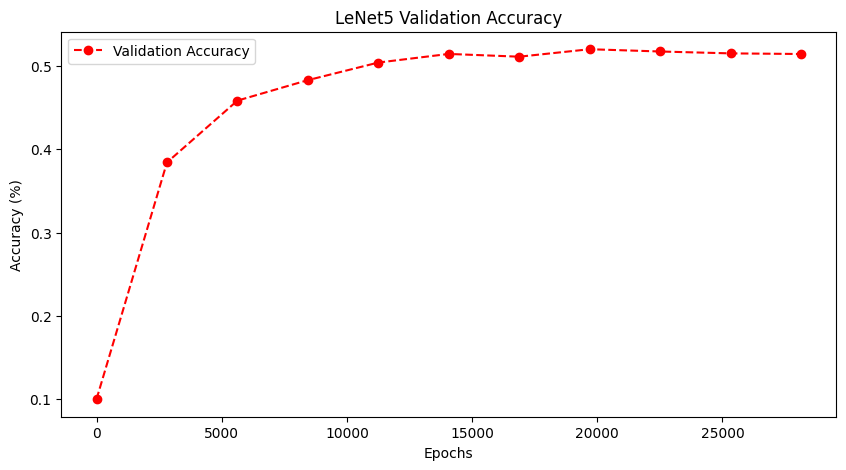

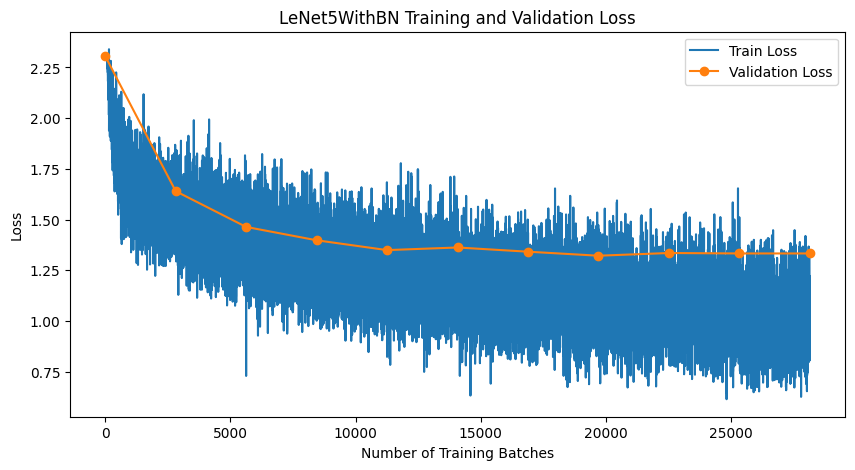

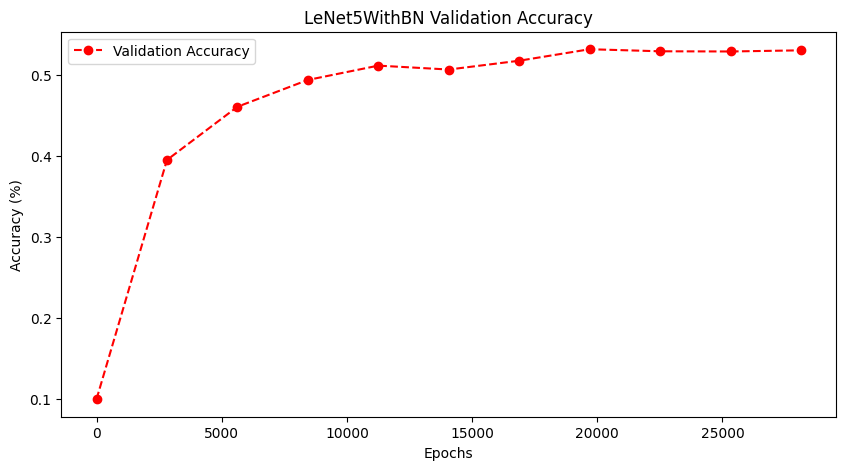

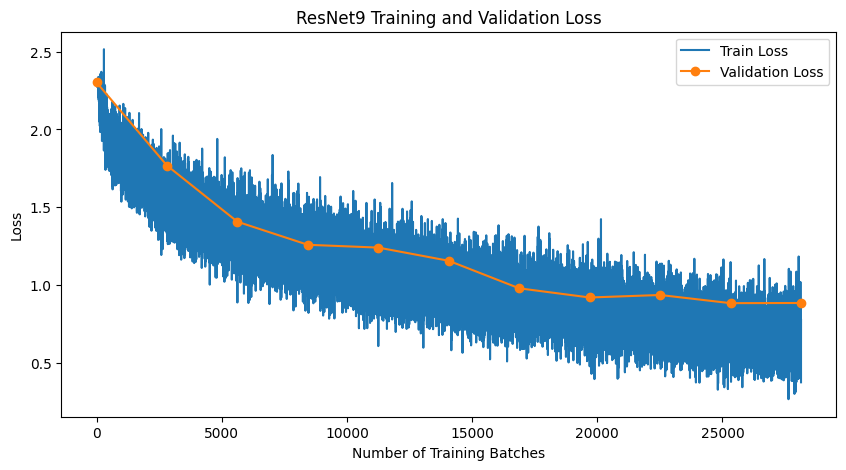

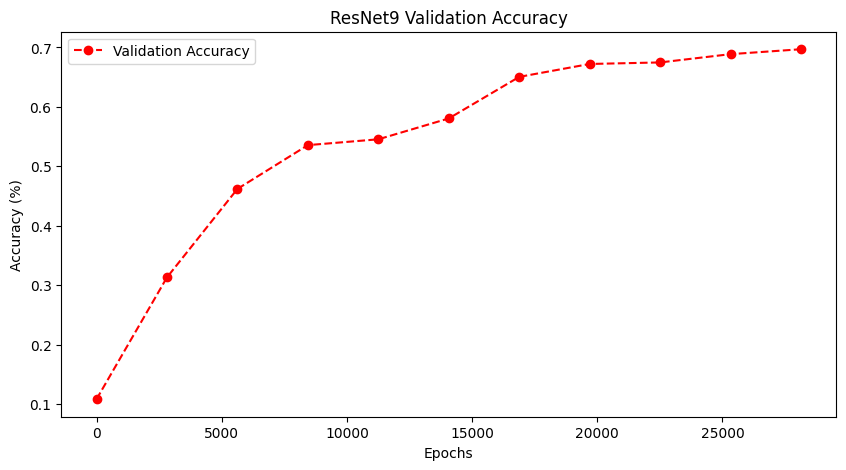

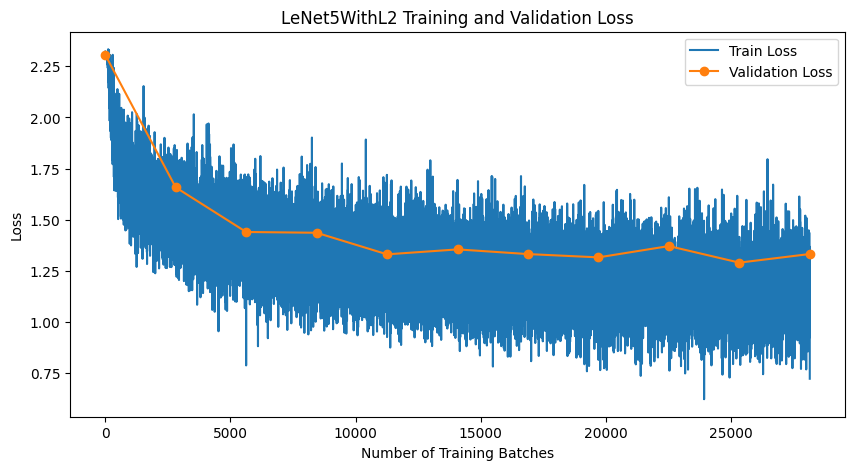

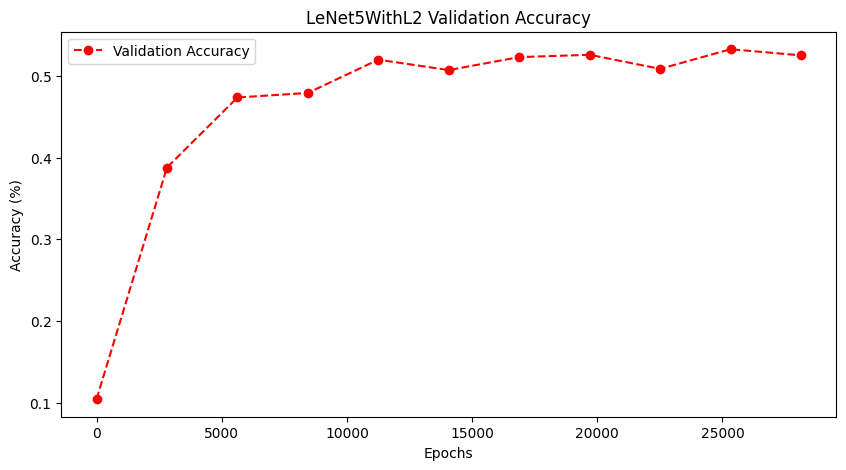

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

class LeNet5WithL2(LeNet5):
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of models including different variations of LeNet
models = [LeNet5(), LeNet5WithBN(), ResNet9(), LeNet5WithL2()]
models = [model.to(device) for model in models]

# Setup optimizers for each model, applying L2 regularization last
optimizers = [
    torch.optim.SGD(models[0].parameters(), lr=0.01, momentum=0.9),
    torch.optim.SGD(models[1].parameters(), lr=0.01, momentum=0.9),
    torch.optim.SGD(models[2].parameters(), lr=0.01, momentum=0.9),
    torch.optim.SGD(models[3].parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)  # L2 regularization
]

loss_fn = nn.CrossEntropyLoss()

# Dictionaries to store training and validation losses and accuracies
train_losses = {model.__class__.__name__: [] for model in models}
valid_losses = {model.__class__.__name__: [] for model in models}
valid_accuracy = {model.__class__.__name__: [] for model in models}

epochs = 20

initial_results = validate_model(cinic_dataset.valid_dataloader, models, loss_fn)
for name, metrics in initial_results.items():
    valid_losses[name].append(metrics[0])
    valid_accuracy[name].append(metrics[1])

# Training loop for the specified number of epochs
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    model_losses = train_model(cinic_dataset.train_dataloader, models, loss_fn, optimizers)
    for name, losses in model_losses.items():
        train_losses[name].extend(losses)

    # Validate every 2 epochs
    if epoch % 2 == 0:
        results = validate_model(cinic_dataset.valid_dataloader, models, loss_fn)
        for name, metrics in results.items():
            valid_losses[name].append(metrics[0])
            valid_accuracy[name].append(metrics[1])

# Plotting training and validation loss for each model
for name in train_losses:
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses[name], label='Train Loss')
    validation_x_ticks = np.arange(0, len(valid_losses[name])) * 2 * len(cinic_dataset.train_dataloader)
    plt.plot(validation_x_ticks, valid_losses[name], label='Validation Loss', marker='o')
    plt.title(f'{name} Training and Validation Loss')
    plt.xlabel('Number of Training Batches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(validation_x_ticks, valid_accuracy[name], label='Validation Accuracy', marker='o', linestyle='--', color='r')
    plt.title(f'{name} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Testing Trained Models
- This code evaluates all four trained models on the test dataset and visualizes their classification performance.

  - Testing Function: test_model calculates the test loss and accuracy for a given model, while recording all predictions and true labels. It then computes a confusion matrix using sklearn.metrics.confusion_matrix to summarize classification results by class.
  - Confusion Matrix Visualization: plot_confusion_matrix displays the confusion matrix with seaborn.heatmap, showing how well the model performed for each class.

Testing LeNet5
Test Accuracy: 50.7%, Avg loss: 1.462757


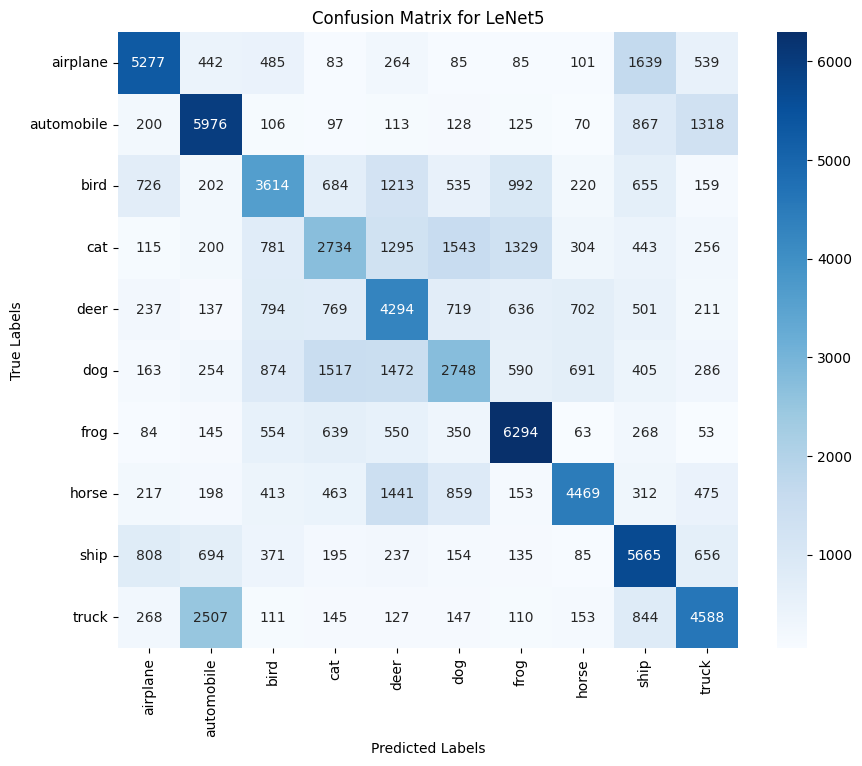

Testing LeNet5WithBN
Test Accuracy: 52.7%, Avg loss: 1.371526


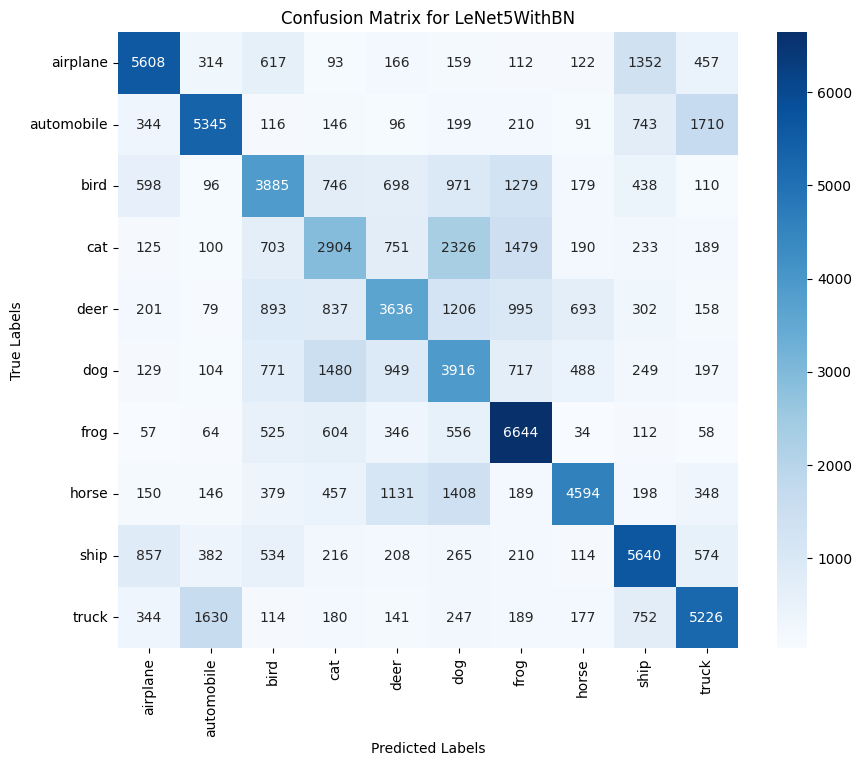

Testing ResNet9
Test Accuracy: 69.8%, Avg loss: 0.881390


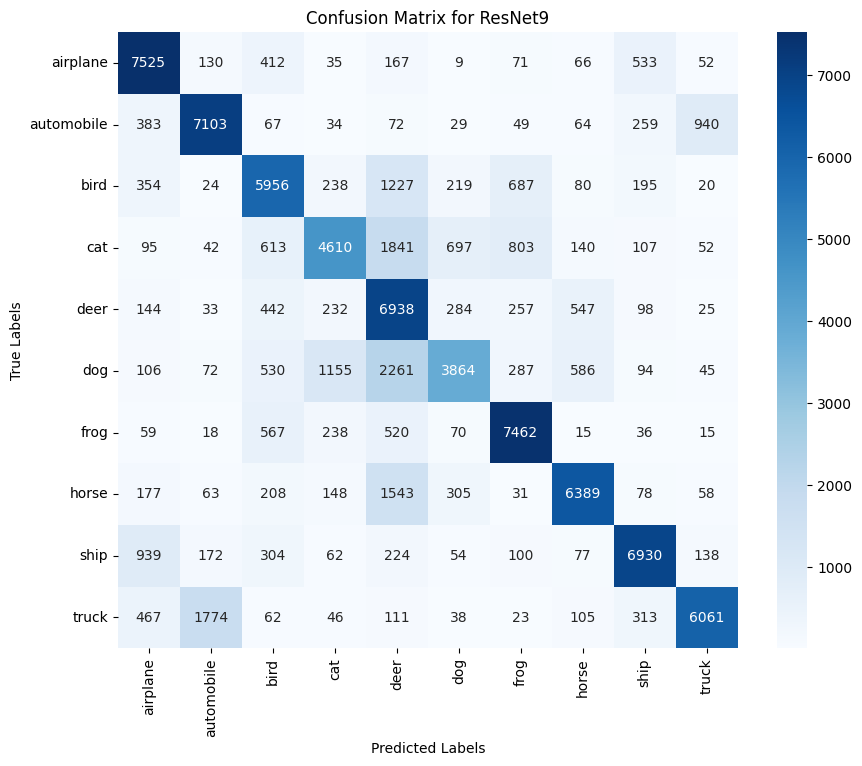

Testing LeNet5WithL2
Test Accuracy: 53.0%, Avg loss: 1.325003


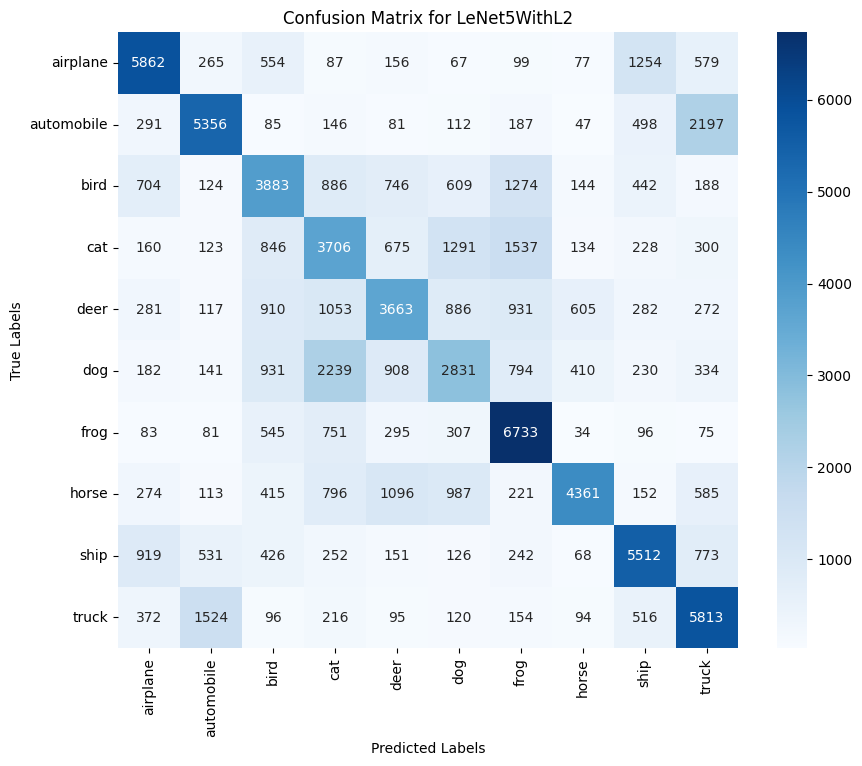

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch
import matplotlib.pyplot as plt

def test_model(dataloader, model, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss, correct = 0, 0

    device = next(model.parameters()).device

    # Disable gradient calculations for performance improvement since they are not needed in evaluation
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute average loss and accuracy over entire dataset
    test_loss /= len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    print(f"Test Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")

    # Generate confusion matrix using true and predicted labels
    cm = confusion_matrix(all_labels, all_preds)
    return cm, accuracy

def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

class_names = cinic_dataset.train_dataset.classes
# Test each model and get confusion matrix and accuracy and plot
for model in models:
    print(f"Testing {model.__class__.__name__}")
    cm, test_accuracy = test_model(cinic_dataset.test_dataloader, model, loss_fn)
    plot_confusion_matrix(cm, class_names, model.__class__.__name__)

## Display Failed Prediction Cases
- Here we display failed prediction cases from the four models. The code processes a batch of data, identifies the incorrect predictions, and visualizes a specified number of these incorrect predictions.

Example failed cases for LeNet5


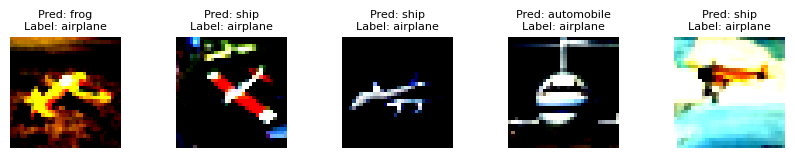

Example failed cases for LeNet5WithBN


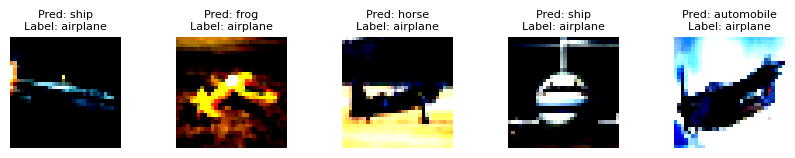

Example failed cases for ResNet9


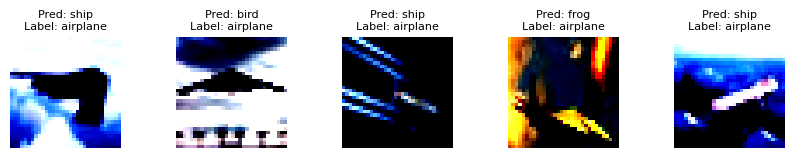

Example failed cases for LeNet5WithL2


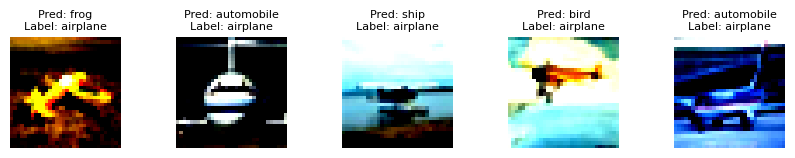

In [22]:
import torch
import matplotlib.pyplot as plt

def display_failed_cases(dataloader, model, class_names, num_examples=5):
    model.eval()
    failed_cases = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            incorrect = preds.argmax(1) != y
            for img, pred, label in zip(X[incorrect], preds[incorrect], y[incorrect]):
                if len(failed_cases) < num_examples:
                    failed_cases.append((img, pred.argmax().item(), label.item()))
                else:
                    break

    # Create figure for each set of failed cases
    plt.figure(figsize=(num_examples * 2, 2))
    for i, (img, pred, label) in enumerate(failed_cases):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img.cpu().permute(1, 2, 0))
        plt.title(f"Pred: {class_names[pred]}\nLabel: {class_names[label]}", fontsize=8)
        plt.axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()
    plt.close()

for model in models:
    print(f"Example failed cases for {model.__class__.__name__}")
    display_failed_cases(cinic_dataset.test_dataloader, model, class_names)